<a href="https://colab.research.google.com/github/abrange/mit-deeplearning/blob/main/module_4/Deep_Learning_Mastering_Neural_Networks_Module_4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Mastering Neural Networks - Module 4 Asignment: CNN Classification of FashionMNIST Dataset

Now that we have Convolutional layers in our deep learning toolkit, we are going tackle a new and more challenging dataset - the [FashionMNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) dataset. This dataset is in a similar format to the MNIST dataset, however it contains images of different articles of clothing.

In this assignment, we ask that you develop a CNN classifier that implements **at least 2** convolutional layers.

A template has been provided below with some starter code and please feel free to reuse any code you have written or seen before in previous notebooks!



In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Notice how FashionMNIST is also built into PyTorch!
fashion_mnist_train = torchvision.datasets.FashionMNIST('', train=True, transform =transform, download=True)

# We will split out train dataset into train and validation!
fashion_mnist_train, fashion_mnist_val = torch.utils.data.random_split(fashion_mnist_train, [int(np.floor(len(fashion_mnist_train)*0.75)), int(np.ceil(len(fashion_mnist_train)*0.25))])

fashion_mnist_test = torchvision.datasets.FashionMNIST('', train=False, transform = transform, download=True)

In [3]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(fashion_mnist_train, batch_size=batch_size),
               'val': DataLoader(fashion_mnist_val, batch_size=batch_size),
               'test': DataLoader(fashion_mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(fashion_mnist_train),
                 'val': len(fashion_mnist_val),
                 'test': len(fashion_mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


## Visualization

Before we go any further, we want to visualize the different datapoints in our dataset. Similar to the MNIST datset, there are 10 different object classes and they map to the following labels:

* 0 - T-shirt/top
* 1 - Trouser
* 2 - Pullover
* 3 - Dress
* 4 - Coat
* 5 - Sandal
* 6 - Shirt
* 7 - Sneaker
* 8 - Bag
* 9 - Ankle boot

Using the function below, we can visualize some of the different images that we will be working with from each class. Additionally, follow this [link](https://www.kaggle.com/datasets/zalando-research/fashionmnist) to find more information on the dataset.

In [4]:
# plot a digit ground truth and autoencoding
def view_fashionmnist(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # we only want to view a certain class
            if (labels[i] != label):
                continue
            # plot the ground truth
            ax = fig.add_subplot(1, count, idx)
            input = input.cpu().detach().numpy().reshape((28,28))
            ax.imshow(input, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

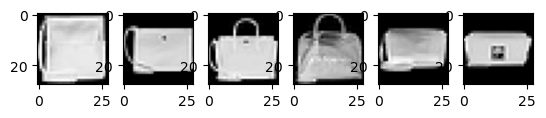

In [5]:
# View 6 bags
view_fashionmnist(8, 6)

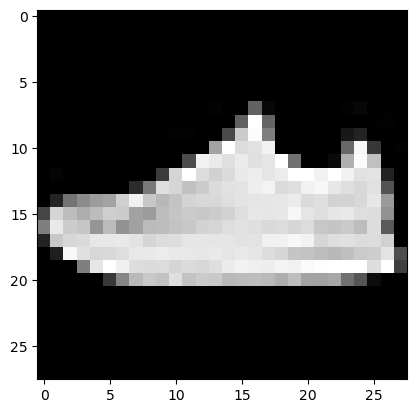

In [6]:
# View 1 sneaker
view_fashionmnist(7, 1)

In [7]:
def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch + 1}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves



### Visualizing Training Curves and Results

In [8]:
# Utility functions for plotting your results!
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


## Your Turn

Use what you have learned so far to develop a CNN classifier that implements **at least 2** convolutional layers.

In [9]:
# Hint! Create a CNNClassifier class that implements a forward function

# class CNNClassifier(nn.Module):
#     def __init__(self):
#         super(CNNClassifier, self).__init__()
#         # Split the Encoder and Decoder

#         self.pipeline =

#     def forward(self, x):
#         return self.pipeline(x)


## [Model 1 of 3] One Convolution Layer Model
- One convolution layer
- No dropout or regularization

In [10]:
from torch.nn.modules.flatten import Flatten
class OneCNNClassifier(nn.Module):
    def __init__(self):
        super(OneCNNClassifier, self).__init__()

        self.pipeline = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Linear(8*14*14, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.pipeline(x)


In [11]:
num_epochs = 15
learning_rate = 0.001
model = OneCNNClassifier().to(device)
print(model)

OneCNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1568, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [12]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
# Make sure you save the training curves along the way for visualization afterwards!
# model, training_curves = train_classification_model(...)

model, training_curves = train_classification_model(model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/15
----------
train Loss: 0.5669 Acc: 0.7980
val   Loss: 0.4096 Acc: 0.8519
test  Loss: 0.4284 Acc: 0.8467

Epoch 2/15
----------
train Loss: 0.3764 Acc: 0.8658
val   Loss: 0.3673 Acc: 0.8660
test  Loss: 0.3842 Acc: 0.8636

Epoch 3/15
----------
train Loss: 0.3366 Acc: 0.8805
val   Loss: 0.3444 Acc: 0.8747
test  Loss: 0.3595 Acc: 0.8712

Epoch 4/15
----------
train Loss: 0.3110 Acc: 0.8895
val   Loss: 0.3259 Acc: 0.8821
test  Loss: 0.3415 Acc: 0.8777

Epoch 5/15
----------
train Loss: 0.2913 Acc: 0.8959
val   Loss: 0.3120 Acc: 0.8876
test  Loss: 0.3282 Acc: 0.8833

Epoch 6/15
----------
train Loss: 0.2750 Acc: 0.9011
val   Loss: 0.3009 Acc: 0.8933
test  Loss: 0.3171 Acc: 0.8867

Epoch 7/15
----------
train Loss: 0.2610 Acc: 0.9064
val   Loss: 0.2918 Acc: 0.8962
test  Loss: 0.3092 Acc: 0.8902

Epoch 8/15
----------
train Loss: 0.2485 Acc: 0.9111
val   Loss: 0.2873 Acc: 0.8974
test  Loss: 0.3047 Acc: 0.8917

Epoch 9/15
----------
train Loss: 0.2373 Acc: 0.9150
val   Loss: 0.2825

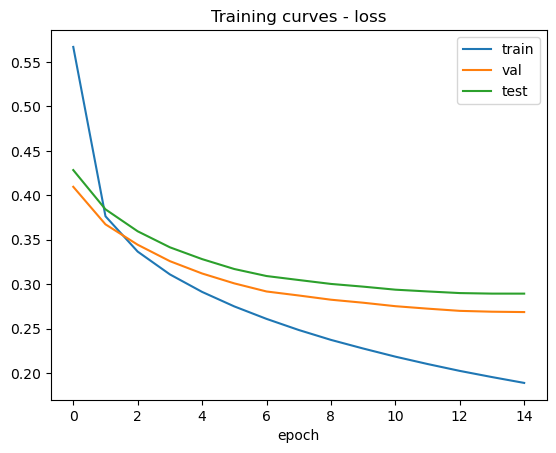

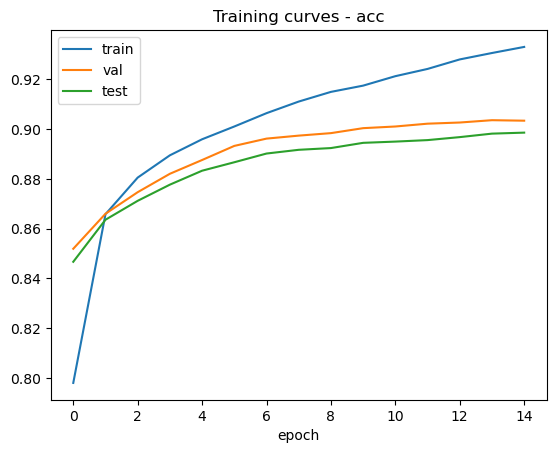

In [13]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

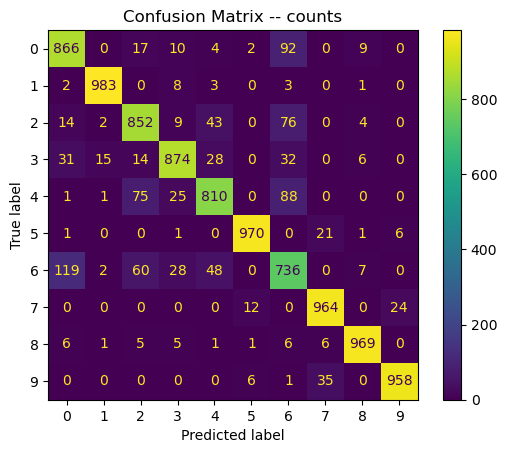

In [14]:
res = plot_cm(model, device, dataloaders, phase='test')

Model 1 Results
- The most incorrectly predicted labels were categories 0 and 6 (T-shirt/top vs Shirt). 105 * 2 = 210 missclassifications for these 2 type of images
- Best val Acc: 0.903600 at epoch 14

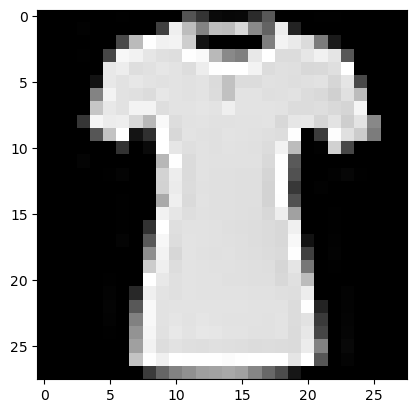

In [15]:
# Sample of T-shirt/top
view_fashionmnist(0, 1)

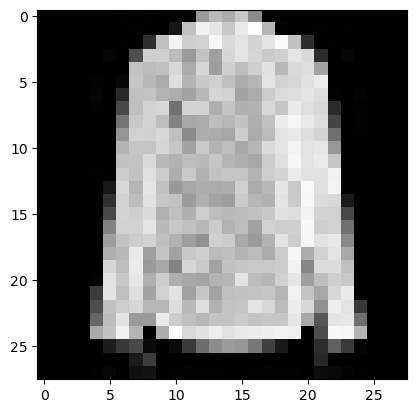

In [16]:
# Sample of a Shirt
view_fashionmnist(6, 1)

## [Model 2 of 3] Model with Two Convolution Layers

In [17]:
from torch.nn.modules.flatten import Flatten
class TwoCNNClassifier(nn.Module):
    def __init__(self):
        super(TwoCNNClassifier, self).__init__()

        self.pipeline = nn.Sequential(
            # First Convolutional
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size will be 8x14x14 (if input is 1x28x28)

            # Second Convolutional
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1), # Takes 8 channels, outputs 16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size will be 16x7x7 = 784

            nn.Flatten(),
            # Adjust the input features for the linear layer based on the new output size
            nn.Linear(16 * 7 * 7, 64), # 16 channels * 7x7 spatial dimensions
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.pipeline(x)


In [18]:
num_epochs = 15
learning_rate = 0.001
model = TwoCNNClassifier().to(device)
print(model)

TwoCNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=784, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [19]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
# Make sure you save the training curves along the way for visualization afterwards!
# model, training_curves = train_classification_model(...)

model, training_curves = train_classification_model(model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/15
----------
train Loss: 0.6525 Acc: 0.7743
val   Loss: 0.4385 Acc: 0.8463
test  Loss: 0.4644 Acc: 0.8355

Epoch 2/15
----------
train Loss: 0.4017 Acc: 0.8571
val   Loss: 0.3722 Acc: 0.8699
test  Loss: 0.3956 Acc: 0.8628

Epoch 3/15
----------
train Loss: 0.3568 Acc: 0.8728
val   Loss: 0.3387 Acc: 0.8779
test  Loss: 0.3602 Acc: 0.8722

Epoch 4/15
----------
train Loss: 0.3271 Acc: 0.8831
val   Loss: 0.3218 Acc: 0.8842
test  Loss: 0.3416 Acc: 0.8779

Epoch 5/15
----------
train Loss: 0.3055 Acc: 0.8900
val   Loss: 0.3082 Acc: 0.8885
test  Loss: 0.3290 Acc: 0.8813

Epoch 6/15
----------
train Loss: 0.2884 Acc: 0.8960
val   Loss: 0.2991 Acc: 0.8895
test  Loss: 0.3218 Acc: 0.8823

Epoch 7/15
----------
train Loss: 0.2748 Acc: 0.9003
val   Loss: 0.2955 Acc: 0.8907
test  Loss: 0.3194 Acc: 0.8849

Epoch 8/15
----------
train Loss: 0.2632 Acc: 0.9039
val   Loss: 0.2914 Acc: 0.8929
test  Loss: 0.3161 Acc: 0.8851

Epoch 9/15
----------
train Loss: 0.2532 Acc: 0.9084
val   Loss: 0.2897

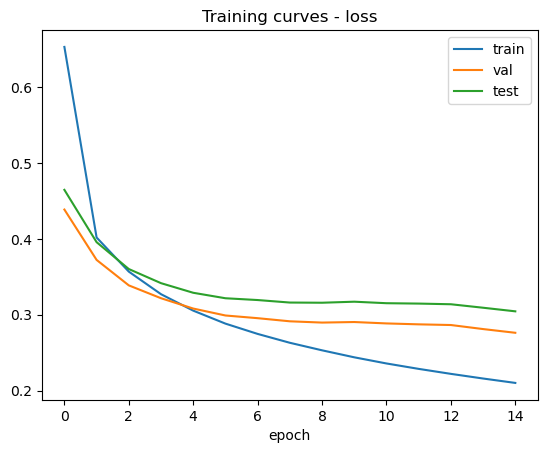

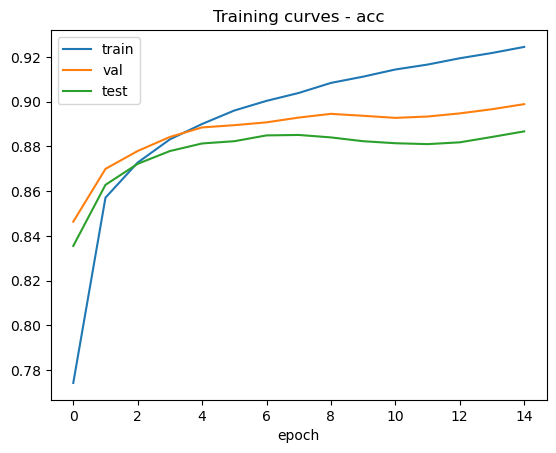

In [20]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

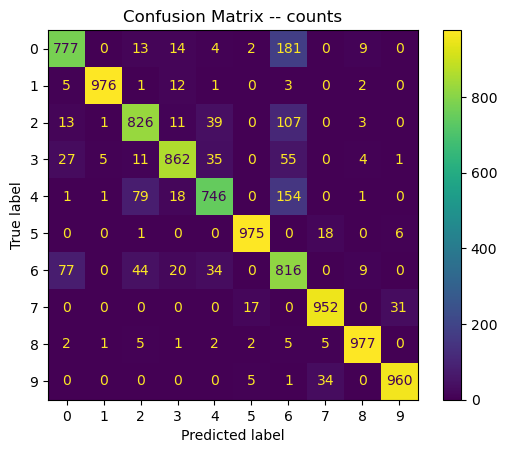

In [21]:
res = plot_cm(model, device, dataloaders, phase='test')

Model 2 results
- The most incorrect classified image was again 6 and 0
- Best val Acc: 0.898867 at epoch 15

## [Model 3] Updated layout, without dropout or regularization

In [22]:
from torch.nn.modules.flatten import Flatten
class TwoCNNClassifierUpdatedArchitecture(nn.Module):
    def __init__(self):
        super(TwoCNNClassifierUpdatedArchitecture, self).__init__()

        self.pipeline = nn.Sequential(
            # First Convolutional
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size will be 8x14x14 (if input is 1x28x28)

            # Second Convolutional
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),

            # Adjust the input features for the linear layer based on the new output size
            nn.Linear(64 * 7 * 7, 128), # Hidden layer: 3,136
            nn.ReLU(),
             
            # Apply Dropout before the last dense layer (or after the ReLU of the first)
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.pipeline(x)


In [23]:
num_epochs = 20
learning_rate = 0.001
model = TwoCNNClassifierUpdatedArchitecture().to(device)
print(model)

TwoCNNClassifierUpdatedArchitecture(
  (pipeline): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [24]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

model, training_curves = train_classification_model(model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/20
----------
train Loss: 0.4882 Acc: 0.8256
val   Loss: 0.3702 Acc: 0.8680
test  Loss: 0.3921 Acc: 0.8605

Epoch 2/20
----------
train Loss: 0.3140 Acc: 0.8877
val   Loss: 0.2873 Acc: 0.8979
test  Loss: 0.3094 Acc: 0.8882

Epoch 3/20
----------
train Loss: 0.2658 Acc: 0.9045
val   Loss: 0.2608 Acc: 0.9054
test  Loss: 0.2817 Acc: 0.8984

Epoch 4/20
----------
train Loss: 0.2347 Acc: 0.9145
val   Loss: 0.2577 Acc: 0.9043
test  Loss: 0.2786 Acc: 0.8960

Epoch 5/20
----------
train Loss: 0.2091 Acc: 0.9236
val   Loss: 0.2560 Acc: 0.9075
test  Loss: 0.2782 Acc: 0.8983

Epoch 6/20
----------
train Loss: 0.1883 Acc: 0.9323
val   Loss: 0.2551 Acc: 0.9105
test  Loss: 0.2785 Acc: 0.8998

Epoch 7/20
----------
train Loss: 0.1681 Acc: 0.9397
val   Loss: 0.2568 Acc: 0.9101
test  Loss: 0.2818 Acc: 0.9015

Epoch 8/20
----------
train Loss: 0.1490 Acc: 0.9473
val   Loss: 0.2574 Acc: 0.9119
test  Loss: 0.2844 Acc: 0.9019

Epoch 9/20
----------
train Loss: 0.1320 Acc: 0.9546
val   Loss: 0.2629

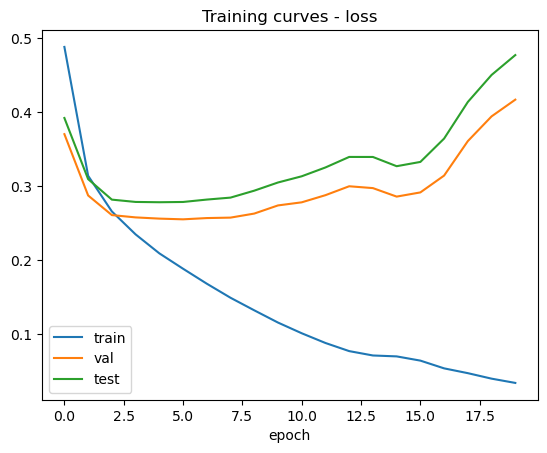

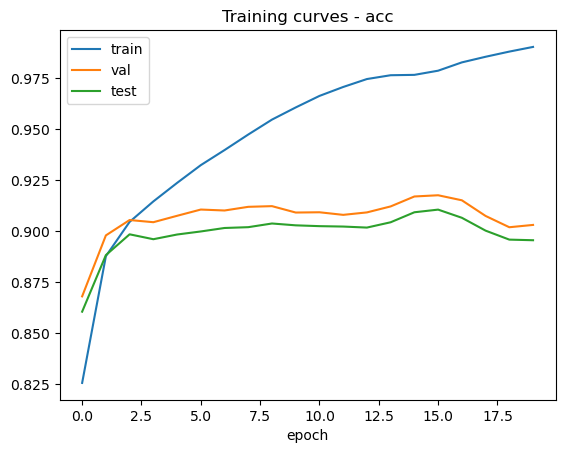

In [25]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

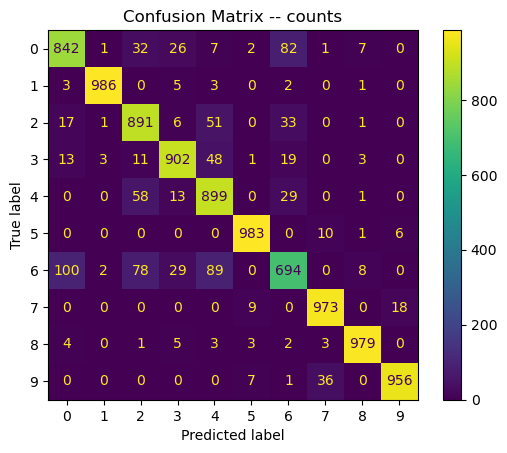

In [26]:
res = plot_cm(model, device, dataloaders, phase='test')

Model 3 results

Best val Acc: 0.917533 at epoch 16

## [Model 4] Two Convolution Layers, with Dropout and Regularization

In [27]:
from torch.nn.modules.flatten import Flatten
class TwoCNNClassifierWithDropout(nn.Module):
    def __init__(self):
        super(TwoCNNClassifierWithDropout, self).__init__()

        self.pipeline = nn.Sequential(
            # First Convolutional
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # Batch Normalization after Conv, before Activation
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size will be 8x14x14 (if input is 1x28x28)
            nn.Dropout2d(p=0.25), # Spatial Dropout after pooling

            # Second Convolutional
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Add Dropout2d after the last pooling layer
            nn.Dropout2d(p=0.25),

            nn.Flatten(),

            # Adjust the input features for the linear layer based on the new output size
            nn.Linear(64 * 7 * 7, 128), # Hidden layer: 3,136
            # nn.Linear(16 * 7 * 7, 64), # 16 channels * 7x7 spatial dimensions
            nn.ReLU(),
             
            # Apply Dropout before the last dense layer (or after the ReLU of the first)
            nn.Dropout(p=0.5), # Another dropout layer for regularization
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.pipeline(x)


In [28]:
num_epochs = 20
learning_rate = 0.001
model = TwoCNNClassifierWithDropout().to(device)
print(model)

TwoCNNClassifierWithDropout(
  (pipeline): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=3136, out_features=128, bias=True)
    (12): ReLU()
    (13): Dropout(p=0.5, inplace=False)
    (14): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [29]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
# Make sure you save the training curves along the way for visualization afterwards!
# model, training_curves = train_classification_model(...)

model, training_curves = train_classification_model(model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/20
----------
train Loss: 0.6018 Acc: 0.7855
val   Loss: 0.3514 Acc: 0.8722
test  Loss: 0.3679 Acc: 0.8657

Epoch 2/20
----------
train Loss: 0.4233 Acc: 0.8485
val   Loss: 0.3000 Acc: 0.8894
test  Loss: 0.3218 Acc: 0.8828

Epoch 3/20
----------
train Loss: 0.3776 Acc: 0.8625
val   Loss: 0.2814 Acc: 0.8922
test  Loss: 0.3043 Acc: 0.8838

Epoch 4/20
----------
train Loss: 0.3430 Acc: 0.8759
val   Loss: 0.2658 Acc: 0.9027
test  Loss: 0.2873 Acc: 0.8955

Epoch 5/20
----------
train Loss: 0.3239 Acc: 0.8820
val   Loss: 0.2546 Acc: 0.9048
test  Loss: 0.2752 Acc: 0.9024

Epoch 6/20
----------
train Loss: 0.3059 Acc: 0.8886
val   Loss: 0.2485 Acc: 0.9064
test  Loss: 0.2723 Acc: 0.9021

Epoch 7/20
----------
train Loss: 0.2918 Acc: 0.8945
val   Loss: 0.2450 Acc: 0.9089
test  Loss: 0.2649 Acc: 0.9050

Epoch 8/20
----------
train Loss: 0.2829 Acc: 0.8969
val   Loss: 0.2341 Acc: 0.9099
test  Loss: 0.2557 Acc: 0.9063

Epoch 9/20
----------
train Loss: 0.2686 Acc: 0.9017
val   Loss: 0.2259

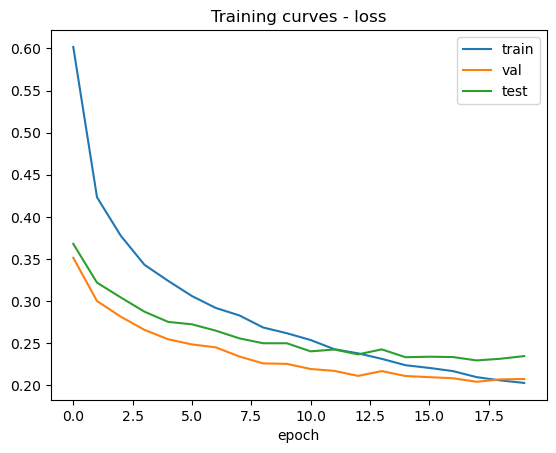

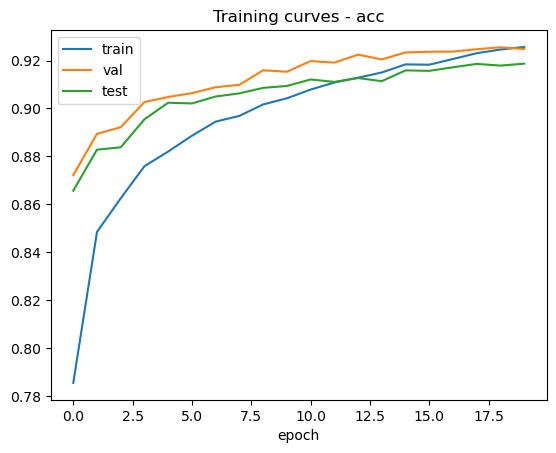

In [30]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

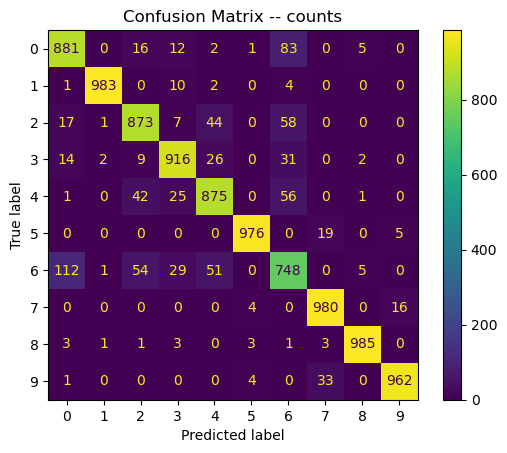

In [31]:
res = plot_cm(model, device, dataloaders, phase='test')

### Visualization of model

In [36]:
# I have used https://netron.app/ web app to generate a visualization of the Model

dummy_input = torch.randn(1, 1, 28, 28)

# 3. Define the output file name
onnx_file_path = "fashion_mnist_cnn.onnx"

# 4. Export the model to ONNX
try:
    torch.onnx.export(
        model,                          # The PyTorch model to export
        dummy_input,                    # A dummy input to trace the model's computation graph
        onnx_file_path,                 # Path to save the ONNX model
        export_params=True,             # Export learned parameters (weights, biases)
        opset_version=11,               # ONNX opset version (choose a compatible one, 11 is common)
        do_constant_folding=True,       # Optimize constants in the graph
        input_names=['input'],          # Name for the input node in the ONNX graph
        output_names=['output'],        # Name for the output node in the ONNX graph
        dynamic_axes={                  # Define dynamic axes for flexible batch size
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"Model successfully exported to {onnx_file_path}")

except Exception as e:
    print(f"Error exporting model to ONNX: {e}")


Model successfully exported to fashion_mnist_cnn.onnx


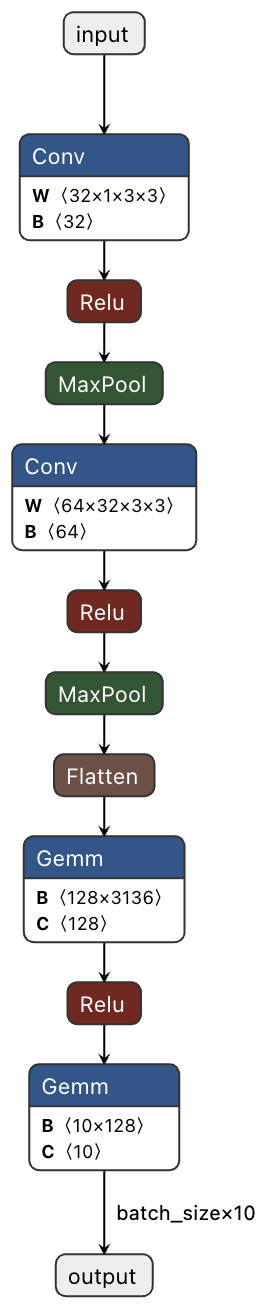

In [34]:
from IPython.display import Image
Image(filename='/Users/abrange/Downloads/fashion_mnist_cnn.onnx.png')

Model 4 Results

Best val Acc: 0.925533 at epoch 19

# Final Assignments Conclusions

- What class of object is most often misclassified?: 0 and 6 (T-Shirts and Shirts)
- What class is it incorrectly classified as most often?: It is 6 (Shirts). In the last model, it was incorrectly classified 1+56+31+58+4+83 = 233 times times based on the Confusion Matrix counts
- Additionally, try re-training your network with dropout included. The Model 4, used both dropout and regularization, and it led to an improvement of 1% in accuracy over Model 3, without regualization!
- Does this help the performance or is there a noticeable change in the ability of the model to generalize?. The model with dropout, regularization had better performance, but not significative (less 1% improvement on accuracy)
- Is the most commonly misclassified object still the same as with no dropout? Yes, in my result, it was still the same object (Shirts)